Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Импорт файла с данными для сравнения:

In [2]:
filename = 'EngineSem.ind'
exp = pd.read_csv(filename, skiprows=list(range(17)) + [18], sep=r'\s+', engine='python', encoding='latin1')
exp.columns = ['Fi', 'Pc', 'Tc', 'Vc', 'Alf_w', 'P_1ring', 'G_bb', 'P_pist', 'x']
exp.head(5)

,Fi,Pc,Tc,Vc,Alf_w,P_1ring,G_bb,P_pist,x
0,180.0,1.93,346.4,0.001056,351.2,1.2636,0.000190,0.000,2.000000e+25
1,181.0,1.93,346.5,0.001055,351.3,1.2637,0.000190,0.007,2.000000e+25
2,182.0,1.93,346.6,0.001055,351.3,1.2639,0.000190,0.027,2.000000e+25
3,183.0,1.93,346.7,0.001055,351.4,1.2641,0.000191,0.062,2.000000e+25
4,184.0,1.93,346.8,0.001055,351.5,1.2644,0.000191,0.109,2.000000e+25


# Исходные данные по двигателю

### Геометрические параметры двигателя

In [3]:
D=0.102          # диаметр цилиндра, м
S=0.122          # ход поршня, м
n_mex=0.82956    # механический КПД
n=2400           # частота вращения, об/мин
icyl=6           # кол-во цилиндров
eps=18           # степень сжатия
lamb=0.264       # R/L

### Граничные и начальные условия

In [4]:
Tk=352            # Температура за компрессором, K
Pk=2.53*1E5       # Давление за компрессором, Па
Tog=862           # Температура ОГ, K
Pog=1.78*1E5      # Давление ОГ, Па

### Топливо

In [5]:
alpha = 2.0      # коэффициент избытка воздуха
L0 = 495.2       # стехиометрическое количество воздуха
# Состав
CG = 0.87
HG = 0.126
OG = 0.004

### Свойства веществ

**Молярные массы веществ:**

In [6]:
ml_sp = {'N2':  0.028,
         'O2':  0.032,
         'CO2': 0.044,
         'H2O': 0.018}

**Мольные доли веществ на впуске и выпуске:**

In [7]:
# Газ на впуске (воздух)
rin = {
    'N2': 0.79,
    'O2': 0.21,
    'CO2': 0,
    'H2O': 0
     }
# Газ на выходе (чистый ОГ)
rout = {
    'N2': 0.7212,
    'O2': 0.0959,
    'CO2': 0.0668,
    'H2O': 0.1161
        }

**Молярная масса - впуск/выпуск:**

In [8]:
ml_in  = sum(ml_sp[comp] * rin[comp] for comp in rin)
ml_out = sum(ml_sp[comp] * rout[comp] for comp in rout)

### Газораспределение и впрыскивание топлива

In [9]:
Fi_ovik = 360-64    # Угол открытия выпускного клапана
Fi_zvik = 540+18    # Угол закрытия выпускного клапапа
Fi_ovk = 540-10     # Угол открытия впускного клапана
Fi_zvk = 42         # Угол закрытия впускного клапана
muf_int = 0.00035    # Максимальное проходное сечения впускного клапана
muf_exh = 0.00035    # Максимальное проходное сечения выпускного клапана
Fi_ovt = 0          # Угол опережения впрыскивания топлива

### Прочие константы

In [10]:
Rm=8.314          # Универсальная газовая постоянная
dFi=np.pi/180     # Приращение угла поворота КВ
N=900             # Статическое количество элементов в массивах

# Функции

### Объем КС как функция угла поворота коленчатого вала:
$$ V(\phi) = V_c + V_h -\frac{\pi D^2} 4 \frac{S} 2 ((1 - cos (\phi))-\frac{\lambda} 4 (1 -cos(2\phi)))$$

In [11]:
def Vol(deg):
    Ap = np.pi * D ** 2 / 4
    Vh = Ap * S
    Vc = Vh / (eps - 1)
    V = Vc + Vh - Ap * S / 2 * (1 - np.cos(np.deg2rad(deg)) - lamb / 4 * (1 - np.cos(2*np.deg2rad(deg))))
    return (V)

### Термодинамическая работа
$$ \frac{dL} {d\phi} = -p\frac{dV}{d\phi} $$

In [12]:
def dL(P, Fi):
    dl = -P * (Vol(Fi+1) - Vol(Fi))/dFi
    return dl

### Теплообмен с окружающими деталями КС:
$$ \frac{dQ_w} {d\phi} = \qquad \sum_{i=1}^3 \alpha_w(T-T_w^i)F_i \frac{dt}{d\omega} $$
Площадь крышки цилиндра:
$$ F_k = \frac{\pi D^2} 4 $$
Площадь поршня:
$$ F_p = 1.4 F_k $$
Площадь гильзы:
$$ F_{cyl}(\phi) = {\pi D}(\delta + S_p(\phi)) $$
Коэффициент теплоотдачи по формуле Г. Эйхельберга:
$$ \alpha_w(\phi) = 77.9 \cdot 10^{-4} C_m^{\frac 1 3} \sqrt{PT} $$

In [13]:
def dQw(P, T, Fi):
    delta = 0.005
    T_h = 473
    T_cyl = 420
    T_p = 521
    Cm = S * n / 30
    Fpist = np.pi*D**2/4
    Vh = Fpist * S
    Vc = Vh / (eps - 1)
    Fcyl = ((Vol(Fi) - Vc) / Fpist + delta) * np.pi * D
    alfa_w =77.9 * 10 ** (-4) * Cm ** (1 / 3) * np.sqrt(P * T)
    dQh = alfa_w * (T - T_h) * 1.4 * Fpist
    dQcyl = alfa_w * (T - T_cyl) * Fcyl
    dQp = alfa_w * (T - T_p) * Fpist
    dqw = -(dQp + dQcyl + dQh) / (np.pi * n / 30)
    return dqw

### Определение теплоемкости смеси газов в КС:


$$ C_v(M, T) = \qquad \sum_{i=1}^4 v_i C_v^i $$  где $v_i =   {M_i} / {M_{mixture}} $ 
$$ C_v^i (T) = \qquad \sum_{i=0}^6 A_i\left({{\frac {T-273.15} {1000}}}\right)^i $$

Таблица 1 – Коэффициенты для аппроксимации изохорной теплоемкости. газовая постоянная газов (Дж/кг/К)|
| Газ | С0       | С1      | С2       | С3       | С4       | С5      | С6      | Ri      |   |
|-----|----------|---------|----------|----------|----------|---------|---------|---------|---|
| H2  | 10077.23 | 1805.88 | -4894.86 | 6962.86  | -4546.27 | 1417.52 | -170.80 | 2124.3  |   |
| O2  | 654.56   | 68.44   | 264.35   | - 393.57 | 246.48   | -73.33  | 8.47    | 259.8   |   |
| N2  | 739.29   | -22.47  | 227.21   | - 185.89 | 70.01    | -12.38  | 0.77    | 296.8   |   |
| H2O | 1397.28  | 116.90  | 349.69   | - 269.54 | 112.47   | -27.73  | 3.05    | 461.6   |   |
| CO  | 2.53     | -27.36  | 118.96   | - 259.99 | 270.41   | -14.11  | 743.45  | 296.8   |   |
| CO2 | 623.42   | 642.051 | -894.27  | 1184.18  | -917.66  | 348.92  | -50.60  | 188.9   |   |0|188.9|




In [14]:
def get_properties(r, T):
    T = (T - 273.15) / 1000
    #  коэффициенты степенного полинома
    Ct = {
        'N2': [739.285131, -22.471670, 227.207844, -185.894180, 70.004916, -12.379265, 0.769710],
        'O2': [654.562116, 68.439046, 264.346543, -393.574630, 246.484449, -73.329697, 8.469622],
        'CO2': [623.417107, 642.051281, -894.274220, 1184.176523, -917.659359, 348.918593, -50.600189],
        'H2O': [1397.282949, 116.902172, 349.689382, -269.541130, 112.473429, -27.731548, 3.047700]
    }
    # Теплоемкость
    N2 = sum([Ct['N2'][k] * T ** k for k in range(0, 6)]) * ml_sp['N2']
    O2 = sum([Ct['O2'][k] * T ** k for k in range(0, 6)]) * ml_sp['O2']
    CO2 = sum([Ct['CO2'][k] * T ** k for k in range(0, 6)]) * ml_sp['CO2']
    H2O = sum([Ct['H2O'][k] * T ** k for k in range(0, 6)]) * ml_sp['H2O']
    Cv = N2 * r['N2'] + O2 * r['O2'] + CO2 * r['CO2'] + H2O * r['H2O']
    return Cv

### Скорость тепловыделения:
*используй коэффициенты, полученные в файла по исследованию процесса сгорания

Для дизельного двигателя можно записать с следующим виде:
$$ \dfrac{dx_{диз}} {d\phi} =  \dfrac{dx_{об}} {d\phi} + \dfrac{dx_{диф}} {d\phi} $$
Для объемного сгорания:
$$ \dfrac{dx_{об}} {d\phi} =\chi_t [\frac{m_t}{\phi_{сг}}][\frac{\phi}{\phi_{сг}}]exp(-\frac{m_t}{m_t+1}[\frac{\phi}{\phi_{сг}}]^{m_t+1})$$
Для диффузионного сгорания:
$$ \dfrac{dx_{диф}} {d\phi} = (1-\chi_t) C [\frac{m_v+1}{\phi_{z}}][\frac{\phi}{\phi_{z}}]exp(-C[\frac{\phi}{\phi_{z}}]^{m_v+1})$$
$ \chi_t $ - доля топлива сгоревшего по кинетическому механизму;

$ m_t $ - показатель кинетического сгорания;

$ \phi_{сг} $ - угол максимального скорости кинетического сгорания;

$ m_v $ - показатель объемного сгорания;

$ С = -ln[1-\Delta x] $ 

$\Delta x $ - доля сгоревшего топлива за весь процесс (обычно принимается ~0.99);

$ \phi_{z} $ - полная продолжительность процесса сгорания.

In [15]:
def HRR (Fi):
    Fi  = Fi-(180-Fi_ovt)
    dx=0.99
    C=-np.log(1-dx)
    Fiz = 3
    ksi = 0.1615
    mt  = 0.7489
    mv  = 1.0983
    Fic = 55.2088
    if (Fi<180) and (Fi>0):
        KiN = (mt/Fiz)*(Fi/Fiz)**mt*np.exp(-mt/(mt+1)*(Fi/Fiz)**(mt+1))
        Dif = C*((mv+1)/Fic)*(Fi/Fic)**mv*np.exp(-C*(Fi/Fic)**(mv+1))
        dXdFi = (ksi*KiN+(1-ksi)*Dif)
    else:
        dXdFi=0
    return dXdFi/dFi

### Теплота выделившаяся при сгорании

$$ \dfrac{dQ_{сг}} {d\phi} = Hu\cdot q_c \dfrac{dx} {d\phi} $$

In [16]:
def Qc (Fi, qc):
    Hu = 42.5*10**6
    return Hu*qc*HRR (Fi)

### Эффективные проходные сечения

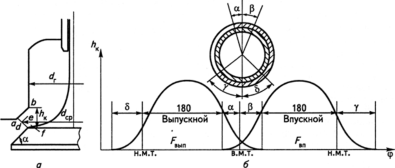

In [17]:
def muf_kl(Fi, indx):
    (Fiok, Fizk, MuMax, muf) = (0, 0, 0, 0)
  
    if indx == 'exh':
        Fiok, Fizk = Fi_ovik, Fi_zvik
        MuMax = muf_exh
    elif indx == 'int':
        Fiok, Fizk = Fi_ovk, Fi_zvk
        MuMax = muf_int
    else:
        print('Ошибка обозначения канала')

    if (Fiok <= Fi) and (Fi <= Fiok + 90):
        muf = MuMax * np.sin((Fi - Fiok)*dFi)
    elif (Fizk - 90 <= Fi) and (Fi <= Fizk):
        muf = MuMax * np.sin((Fi - Fizk + 180)*dFi)
    elif (Fizk - 90 + 720 <= Fi) and (Fi <= Fizk + 720):
        muf = MuMax * np.sin((Fi - Fizk + 180)*dFi)
    elif ((Fiok + 90 < Fi) and (Fi < Fizk - 90)) and (indx == 'exh'):
        muf = MuMax
    elif (Fiok + 90 < Fi) and (Fi < Fizk + 720 - 90) and (indx == 'int'):
        muf = MuMax
    else:
        muf = 0
    return muf

### Определение расхода и энтальпии газа при газообмене

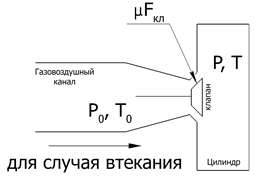

Функция ***GetFlowRate(P, T, Moles, Fi, indx)*** рассчитывает массовый расход газа через впускной или выпускной клапан

---

###  🔸 Выбор канала

В начале функции по аргументу `indx` выбираются для какого канала будет производится расчет - впускного или выпускного:

- если `indx = 'exh'` → берём **выпуск**:  
  - температура: $T_{\text{far}} = T_{og}$  
  - давление: $P_{\text{far}} = P_{og}$  
  - состав: заданный для ОГ $ r_{\text{far}} = r_{\text{out}}  $
- если `indx = 'int'` → берём **впуск**:  
  - температура: $T_{\text{far}} = T_k$  
  - давление: $P_{\text{far}} = P_k$  
  - состав: заданный для воздуха $ r_{\text{far}} = r_{\text{in}}  $

---

### 🔸 Определение направления потока

Направление движения газа определяется сравнением давления в цилиндре $P$ и давления в канале $P_{\text{far}}$ (впускном или выпускном тракте).

- Если давление в цилиндре **выше**, чем в канале ($P \ge P_{\text{far}}$), газ выходит **из цилиндра** → используем отрицательный знак:

  $$
  \text{sign} = -1, \qquad
  P_{\text{in}} = P, \qquad
  T_{\text{in}} = T, \qquad
  P_{\text{out}} = P_{\text{far}}.
  $$

- Если давление в цилиндре **ниже**, чем в канале ($P < P_{\text{far}}$), газ поступает **в цилиндр** → используем положительный знак:

  $$
  \text{sign} = +1, \qquad
  P_{\text{in}} = P_{\text{far}}, \qquad
  T_{\text{in}} = T_{\text{far}}, \qquad
  P_{\text{out}} = P.
  $$

Итоговое условие для направления потока:

$$
\text{sign} =
\begin{cases}
+1, & P < P_{\text{far}} \quad (\text{впуск}) \\
-1, & P \ge P_{\text{far}} \quad (\text{выпуск})
\end{cases}
$$

Таким образом, знак `sign` определяет направление обмена массой между цилиндром и каналом:
- при $\text{sign} = +1$ — приток газа в цилиндр,  
- при $\text{sign} = -1$ — отток газа из цилиндра.

Направление потока не связано с формальным выбором **впускные/выпускные каналы**, и зависит от соотношения давлений по обе стороны от проходного сечения. Возможен вариант, когда будет обратный заброс воздуха во впускной канал

---

### ⚙️ Основное уравнение 

$$
\frac{dG}{dt} = \mu_{\text{кл}}(\varphi) \psi  \sqrt{p_{in} \rho_{in}} 
$$

где  
- $ \mu_{\text{кл}}(\varphi) $ — эффективное проходное сечение клапанной щели;  
- $ p_{in} $ — давление во входном сечении (определяется по соотношению давлений);  
- $ \rho_{in} $ — плотность во входном сечении (определяется по соотношению давлений);  
- $ \psi $ — газодинамическая функция.

---

### 🔸 Газодинамическая функция $ \psi $ 

$$
\psi =
\sqrt{
\frac{2\gamma}{\gamma - 1}
\left[
\left(\frac{p_{\text{out}}}{p_{\text{in}}}\right)^{2/\gamma}
-
\left(\frac{p_{\text{out}}}{p_{\text{in}}}\right)^{(\gamma + 1)/\gamma}
\right]
}
$$

Если поток становится **сверхкритическим**:

$$
p_{\text{in}} > p_{\text{out}}
\left(\frac{2}{\gamma + 1}\right)^{\frac{\gamma}{\gamma - 1}}
$$

то принимается постоянное критическое значение:

$$
\psi =
\sqrt{\frac{2}{\gamma + 1}}
\left(\frac{2\gamma}{\gamma + 1}\right)^{1/2}
$$

---

### 🔸 Массовый расход через клапан

Массовый расход газа через клапан рассчитывается с учётом  
коэффициента расхода, газодинамической функции и направления потока.  

Общее уравнение имеет вид:
$$
\frac{dG}{d\varphi} = \text{sign} \cdot \mu_{\text{кл}}(\varphi) \psi \sqrt{p_{in} \rho_{in}}  \frac{1}{\omega}$$

где  

- $ \frac{dG}{d\varphi} $ — массовый расход газа, кг/рад (в правой части добавлена $\frac{1}{\omega}$ после перехода от времени к углу поворота);  
- $ \text{sign} $ — направление потока:  
  - $ +1 $ — газ поступает в цилиндр;  
  - $ -1 $ — газ выходит из цилиндра;  
- $ \mu_{\text{кл}}(\varphi) $ — коэффициент расхода клапана,  
  зависящий от угла открытия клапана $\varphi$;  
- $ \psi $ — газодинамическая функция (учитывает сжимаемость и режим течения — докритический или сверхкритический);  
- $ P_{\text{in}} $ — давление на стороне входа потока (Па);  
- $ T_{\text{in}} $ — температура на стороне входа потока (К);  
- $ \mu_{\text{смеси}} $ — средняя молярная масса газовой смеси (кг/моль) - той которая протекает через сечение - для случая если из цилиндра, нужно считать по соответствующему составу смеси.

---

### 🔸 Переход от массового расхода к мольному

Основной цикл у нас по молям, поэтому нужно выполнить переход

$$
\frac{dM}{d\varphi}  =\frac{1}{\mu_{\text{смеси}}} \frac{dG}{d\varphi}  
$$

---

#### 🔸 Разбивка мольного расхода по компонентам смеси в цилиндре


Общий мольный расход смеси $\frac{dM}{d\varphi}$ распределяется между компонентами пропорционально их долям:

$$
\begin{aligned}
\frac{dM_{\mathrm{N_2}}}{d\varphi} &= r_{\mathrm{N_2}} \, \frac{dM}{d\varphi}, \\
\frac{dM_{\mathrm{O_2}}}{d\varphi}&= r_{\mathrm{O_2}} \, \frac{dM}{d\varphi}, \\
\frac{dM_{\mathrm{CO_2}}}{d\varphi} &= r_{\mathrm{CO_2}} \, \frac{dM}{d\varphi}, \\
\frac{dM_{\mathrm{H_20}}}{d\varphi} &= r_{\mathrm{H_2O}} \, \frac{dM}{d\varphi}.
\end{aligned}
$$

или в компактной форме:

$$
\frac{dM_i}{d\varphi} = r_i \, \frac{dM}{d\varphi}, \qquad
i \in \{\mathrm{N_2}, \mathrm{O_2}, \mathrm{CO_2}, \mathrm{H_2O}\}.
$$



### 🔸 Энтальпия потока

$$
\frac{dH}{d\varphi}  =C_p T \frac{dM}{d\varphi} , \qquad C_p = C_v + R_m
$$




In [18]:
def GetFlowRate(P, T, r0, Fi, indx):
    dM0 = {
        'N2': 0,
        'O2': 0,
        'CO2': 0,
        'H2O': 0,
        'Mixture': 0
    }
    ml0 = r0['N2'] * ml_sp['N2'] + r0['O2'] * ml_sp['O2'] +r0['CO2'] * ml_sp['CO2'] + r0['H2O'] * ml_sp['H2O']
    # Проверка канала
    if indx == 'exh':
        Tfar, Pfar  = Tog, Pog
        mlfar = ml_out
        rfar = rout
    elif indx == 'int':
        Tfar, Pfar = Tk, Pk
        mlfar = ml_in
        rfar = rin
    else:
        print('Ошибка обозначения канала')
    # Проверка входа/выхода
    if P >= Pfar:
        Pint, Tin = P, T
        Pout = Pfar
        sign = -1
        r = r0
        ml = ml0
    else:
        Pint, Tin = Pfar, Tfar
        Pout = P
        sign = 1
        r = rfar
        ml = mlfar
    # Пси
    cp = get_properties(r, Tin) + Rm
    k =cp / get_properties(r, Tin)
    if P > pow((k+1)/2, k/(k-1))*Pfar:
        psi = pow(2/(k+1), 1/(k-1))*(2*k/(k+1))**0.5
    else:
        dp = (Pout/Pint)
        psi = (2*k/(k-1)*(dp**(2/k)-dp**((k+1)/k)))**0.5

    dG = sign*muf_kl(Fi, indx)*psi*(Pint*Pint/Rm/Tin*ml)**0.5/(np.pi*n/30)
    dM0['Mixture'] = 1 / ml * dG
    dM0['N2'] = r['N2'] * dM0['Mixture']
    dM0['O2'] = r['O2'] * dM0['Mixture']
    dM0['CO2'] = r['CO2'] * dM0['Mixture']
    dM0['H2O'] = r['H2O'] * dM0['Mixture']
    dH = cp * Tin * dM0['Mixture']
    return dM0, dH

# Основная программа

### Объявление массивов

In [19]:
P = np.zeros((N+1, 1))             # давление, Па
T = np.zeros((N+1, 1))             # температура, K
# кол-во вещества, моль
components = ['N2', 'O2', 'CO2', 'H2O']
M = {
    'N2':  np.zeros((N+1, 1)),
    'O2':  np.zeros((N+1, 1)),
    'CO2': np.zeros((N+1, 1)),
    'H2O': np.zeros((N+1, 1)),
    'Mixture': np.zeros((N+1, 1))
    }
dMdFi = {
    'N2':  np.zeros((N+1, 1)),
    'O2':  np.zeros((N+1, 1)),
    'CO2': np.zeros((N+1, 1)),
    'H2O': np.zeros((N+1, 1)),
    'Mixture': np.zeros((N+1, 1))
    }

### Начальные данные для расчета рабочего процесса

Возьмем значения в цилиндре двигателя на момент его закрытия, равными "экспериментальным"

In [20]:
P[Fi_zvk] = exp['Pc'][Fi_zvk]*1e5
T[Fi_zvk] = exp['Tc'][Fi_zvk]
dM = 0                             # изменение состава смеси в КС в начальный момент времени

Состав смеси газов на момент закрытия впускного клапана = воздух

In [21]:
M['Mixture'][Fi_zvk] = P[Fi_zvk] * Vol(Fi_zvk) / T[Fi_zvk] / Rm
M['N2'][Fi_zvk] = 0.79 * M['Mixture'][Fi_zvk]
M['O2'][Fi_zvk] = 0.21 * M['Mixture'][Fi_zvk]
M['CO2'][Fi_zvk] = 0
M['H2O'][Fi_zvk] = 0

In [22]:
M['Mixture'][Fi_zvk]

array([0.06983642])

По коэффициенту избытка воздуха можно определить соответствующую цикловую подачу

In [23]:
qc = M['Mixture'][Fi_zvk]/L0/alpha
qc.tolist()

[7.051334474327769e-05]

### Расчет процесса сжатия

Для процесса сжатия алгебраическая система уравнений для закрытой термодинамической системы решается последовательно в цикле:

получаем теплоемкость смеси
$$ c_v =   \text{get\_properties} (r_{Fi}, T_{Fi})$$
считаем изменение температуры в цилиндре двигателя
$$ \Delta T = \frac{\dfrac{dL}{d\phi}\bigg|_{Fi} + \dfrac{dQ_w} {d\phi} \bigg|_{Fi}} {C_v(Fi)\cdot M_{mixture}(Fi)} $$
$$ T_{Fi+1} = T_{Fi} + \Delta Fi \cdot \Delta T  $$
обновляем состава смеси в цилиндре двигателя (он пока не меняется)
$$ M {[NO2]}_{Fi+1} = M {[NO2]}_{Fi} + 0 $$
$$ M {[CO2]}|_{Fi+1} = M {[CO2]}_{Fi} + 0  $$
$$ M {[N2]}_{Fi+1} = M {[N2]}_{Fi} + 0 $$
$$ M {[O2]}_{Fi+1} = M {[O2]}_{Fi} + 0 $$
$$ M {[Mixture]}_{Fi+1} = \qquad \sum_{i=1}^4 M^i_{Fi+1} $$
считаем изменение давление в цилиндре двигателя
$$ p_{Fi+1} = \frac {M {[Mixture]}_{Fi+1} T_{Fi+1} R_m} {V_{Fi+1}}  $$

In [24]:
for Fi in range (Fi_zvk, 180 - Fi_ovt):
    cv = get_properties({sp: M[sp][Fi]/M['Mixture'][Fi] for sp in components}, T[Fi])
    dT = (dL(P[Fi], Fi) + dQw(P[Fi], T[Fi], Fi))/ cv / M['Mixture'][Fi]
    T[Fi + 1] = T[Fi] + dT * dFi

    M['N2'][Fi+1] =  M['N2'][Fi]  
    M['O2'][Fi+1] =  M['O2'][Fi]  
    M['CO2'][Fi+1] = M['CO2'][Fi] 
    M['H2O'][Fi+1] = M['H2O'][Fi]
    M['Mixture'][Fi+1] = M['N2'][Fi+1]+M['O2'][Fi+1]+M['CO2'][Fi+1]+M['H2O'][Fi+1]
    
    P[Fi+1] = M['Mixture'][Fi+1]*T[Fi+1]*Rm/Vol(Fi+1)
    

### Расчет процесса сжатия - сгорания - расширения

Для процесса сгорания алгебраическая система уравнений для закрытой термодинамической системы решается последовательно в цикле:

получаем теплоемкость смеси
$$ c_v =   \text{get\_properties} (r_{Fi}, T_{Fi})$$
считаем изменение температуры в цилиндре двигателя
$$ \Delta T = \frac{\dfrac{dL}{d\phi}\bigg|_{Fi} + \dfrac{dQ_w} {d\phi} \bigg|_{Fi} +  \dfrac{dQ_{сг}} {d\phi} \bigg|_{Fi} -  c_v\cdot T(Fi)\cdot \dfrac{dM} {d\phi} \bigg|_{Fi}         } {C_v(Fi)\cdot M_{mixture}(Fi)} $$
$$ T_{Fi+1} = T_{Fi} + \Delta Fi \cdot \Delta T  $$
считаем изменение состава смеси в цилиндре двигателя
$$ M {[N2]}_{Fi+1} = M {[N2]}_{Fi} + 0 $$
$$ M {[O2]}_{Fi+1} = M {[O2]}_{Fi} - 0.21 \cdot L_0 \cdot q_c \cdot  \dfrac{dx} {d\phi} \bigg|_{Fi} $$
$$ M {[H2O]}_{Fi+1} = M {[H2O]}_{Fi} +  \dfrac{HG} {0.002} \cdot q_c \cdot \dfrac{dx} {d\phi} \bigg|_{Fi}  $$
$$ M {[CO2]}|_{Fi+1} = M {[CO2]}_{Fi} + \dfrac{CG} {0.012} \cdot q_c \cdot \dfrac{dx} {d\phi} \bigg|_{Fi}  $$
$$ M {[Mixture]}_{Fi+1} = \qquad \sum_{i=1}^4 M^i_{Fi+1} $$
считаем изменение давление в цилиндре двигателя
$$ p_{Fi+1} = \frac {M {[Mixture]}_{Fi+1} T_{Fi+1} R_m} {V_{Fi+1}}  $$

In [25]:
dM = 0
for Fi in range (180 - Fi_ovt, Fi_ovik):
    cv = get_properties({sp: M[sp][Fi]/M['Mixture'][Fi] for sp in components}, T[Fi])
    dT = (dL(P[Fi], Fi) + dQw(P[Fi], T[Fi], Fi) + Qc (Fi, qc) -cv*T[Fi]*dMdFi['Mixture'][Fi])/ cv / M['Mixture'][Fi]
    T[Fi + 1] = T[Fi] + dT * dFi
    dMdFi['N2'][Fi+1] = 0
    dMdFi['O2'][Fi+1] = -0.21*L0*HRR(Fi)*qc
    dMdFi['CO2'][Fi+1] = CG/0.012*HRR(Fi)*qc
    dMdFi['H2O'][Fi+1] = HG/0.002*HRR(Fi)*qc
    dMdFi['Mixture'][Fi+1] = sum(dMdFi[sp][Fi] for sp in components)
    M['N2'][Fi+1] = M['N2'][Fi] + dMdFi['N2'][Fi]*dFi
    M['O2'][Fi+1] = M['O2'][Fi] + dMdFi['O2'][Fi]*dFi
    M['CO2'][Fi+1] = M['CO2'][Fi] + dMdFi['CO2'][Fi]*dFi
    M['H2O'][Fi+1] = M['H2O'][Fi] + dMdFi['H2O'][Fi]*dFi
    M['Mixture'][Fi+1]  = sum(M[sp][Fi+1] for sp in components)
    
    P[Fi+1] = M['Mixture'][Fi+1]*T[Fi+1]*Rm/Vol(Fi+1)

### Расчет процесса газообмена

Для процесса газообмена алгебраическая система уравнений для открытой термодинамической системы решается последовательно в цикле:
получаем теплоемкость смеси
$$ c_v =   \text{get\_properties} (r_{Fi}, T_{Fi})$$
получаем расходы через клапана и энтальпию
$$  [dM_{in}, dH_{in}] = GetFlowRate(P_{Fi}, T_{Fi}, r_{Fi}, Fi, 'intake') $$ 
$$  [dM_{exh}, dH_{exh}] = GetFlowRate(P_{Fi}, T_{Fi}, r_{Fi}, Fi, 'exhaust') $$ 
обновляем общий расход газов по компонентам
$$ \frac{dM {[N2]}} {dFi} \bigg|_{Fi+1} =  dM{[N2]}_{in} - dM{[N2]}_{exh}$$
$$ \frac{dM {[O2]}} {dFi} \bigg|_{Fi+1} =  - 0.21 \cdot L_0 \cdot q_c \cdot  \dfrac{dx} {d\phi} \bigg|_{Fi} +dM{[O2]}_{in} - dM{[O2]}_{exh}$$
$$ \frac{dM {[H2O]}} {dFi} \bigg|_{Fi+1} = \dfrac{HG} {0.002} \cdot q_c \cdot \dfrac{dx} {d\phi} \bigg|_{Fi}  +dM{[H2O]}_{in} - dM{[H2O]}_{exh}$$
$$ \frac{dM {[CO2]}} {dFi} \bigg|_{Fi+1} = \dfrac{CG} {0.012} \cdot q_c \cdot \dfrac{dx} {d\phi} \bigg|_{Fi}  +dM{[CO2]}_{in} - dM{[CO2]}_{exh}$$
$$ \frac{dM {[mixture]}} {dFi} \bigg|_{Fi+1} = \frac{dM {[N2]}} {dFi} \bigg|_{Fi+1} + \frac{dM {[O2]}} {dFi} \bigg|_{Fi+1} + \frac{dM {[H2O]}} {dFi} \bigg|_{Fi+1} + \frac{dM {[CO2]}} {dFi} \bigg|_{Fi+1}  $$
считаем количества газа по компонентам на следующем шаге

$$ M {[N2]}_{Fi+1} = M {[N2]}_{Fi}    + \frac{dM {[N2]}} {dFi} \bigg|_{Fi+1} \cdot \Delta Fi$$
$$ M {[O2]}_{Fi+1} = M {[O2]}_{Fi}    + \frac{dM {[O2]}} {dFi} \bigg|_{Fi+1} \cdot \Delta Fi$$
$$ M {[H2O]}_{Fi+1} = M {[H2O]}_{Fi}  + \frac{dM {[H2O]}} {dFi} \bigg|_{Fi+1} \cdot \Delta Fi$$
$$ M {[CO2]}|_{Fi+1} = M {[CO2]}_{Fi} + \frac{dM {[CO2]}} {dFi} \bigg|_{Fi+1} \cdot \Delta Fi$$
$$ M {[Mixture]}_{Fi+1} = \qquad \sum_{i=1}^4 M^i_{Fi+1}$$

определяем температуру в цилиндре двигателя

$$ \Delta T = 
\frac{\dfrac{dL}{d\phi}\bigg|_{Fi} + \dfrac{dQ_w} {d\phi} \bigg|_{Fi} +  
\dfrac{dQ_{сг}} {d\phi} \bigg|_{Fi} -  c_v\cdot T(Fi)\cdot \dfrac{dM} {d\phi} \bigg|_{Fi} +  \dfrac{dH_{in}} {d\phi} \bigg|_{Fi} -  \dfrac{dH_{out}} {d\phi} \bigg|_{Fi}} {C_v(Fi)\cdot M_{mixture}(Fi)} $$
$$ T_{Fi+1} = T_{Fi} + \Delta Fi \cdot \Delta T  $$
определяем давление в цилиндра двигателя
$$ p_{Fi+1} = \frac {M {[Mixture]}_{Fi+1} T_{Fi+1} R_m} {V_{Fi+1}}  $$

In [26]:
dHin = 0
dHout = 0
for Fi in range (Fi_zvk, 720+Fi_zvk):
    cv = get_properties({sp: M[sp][Fi]/M['Mixture'][Fi] for sp in components}, T[Fi])
   
  
    [dMin, dHin]   = GetFlowRate(P[Fi], T[Fi], {sp: M[sp][Fi]/M['Mixture'][Fi] for sp in components}, Fi, 'int')
    [dMout, dHout] = GetFlowRate(P[Fi], T[Fi], {sp: M[sp][Fi]/M['Mixture'][Fi] for sp in components}, Fi, 'exh')    

    
    dMdFi['N2'][Fi+1] = 0+dMin['N2']+dMout['N2']
    dMdFi['O2'][Fi+1] = -0.21*L0*HRR(Fi)*qc + dMin['O2'] + dMout['O2']
    dMdFi['CO2'][Fi+1] = CG/0.012*HRR(Fi)*qc + dMin['CO2'] + dMout['CO2']
    dMdFi['H2O'][Fi+1] = HG/0.002*HRR(Fi)*qc + dMin['H2O'] + dMout['H2O']
    dMdFi['Mixture'][Fi+1] = sum(dMdFi[sp][Fi] for sp in components)
    M['N2'][Fi+1] = M['N2'][Fi] + dMdFi['N2'][Fi]*dFi
    M['O2'][Fi+1] = M['O2'][Fi] + dMdFi['O2'][Fi]*dFi
    M['CO2'][Fi+1] = M['CO2'][Fi] + dMdFi['CO2'][Fi]*dFi
    M['H2O'][Fi+1] = M['H2O'][Fi] + dMdFi['H2O'][Fi]*dFi
    M['Mixture'][Fi+1]  = sum(M[sp][Fi+1] for sp in components)

    dT = (dL(P[Fi], Fi) + dQw(P[Fi], T[Fi], Fi) 
                        + Qc (Fi, qc)
                        + dHin + dHout
                        -cv*T[Fi]*dMdFi['Mixture'][Fi+1])/ cv / M['Mixture'][Fi]
    T[Fi + 1] = T[Fi] + dT * dFi 
    
    
    P[Fi+1] = M['Mixture'][Fi+1]*T[Fi+1]*Rm/Vol(Fi+1)

# Отображение результатов 

Графики давления и температуры в КС

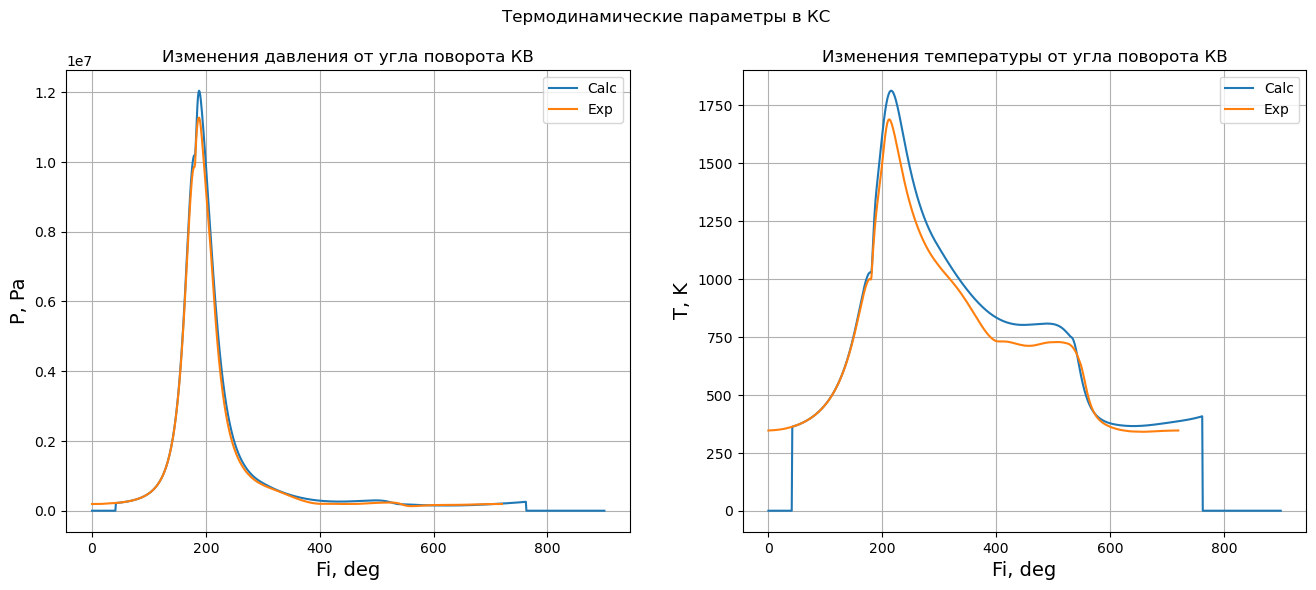

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Термодинамические параметры в КС')
# График давления
ax[0].set_title('Изменения давления от угла поворота КВ')
ax[0].set_ylabel('P, Pa', fontsize=14)
ax[0].set_xlabel('Fi, deg', fontsize=14)
ax[0].plot(P, label = 'Calc')
ax[0].plot(exp['Pc']*1e5, label = 'Exp')
# График температуры
ax[1].set_title('Изменения температуры от угла поворота КВ')
ax[1].set_ylabel('T, K', fontsize=14)
ax[1].set_xlabel('Fi, deg', fontsize=14)
ax[1].plot(T, label = 'Calc')
ax[1].plot(exp['Tc'], label = 'Exp')
[[ax.legend(), ax.grid(True)] for ax in ax]
plt.show()

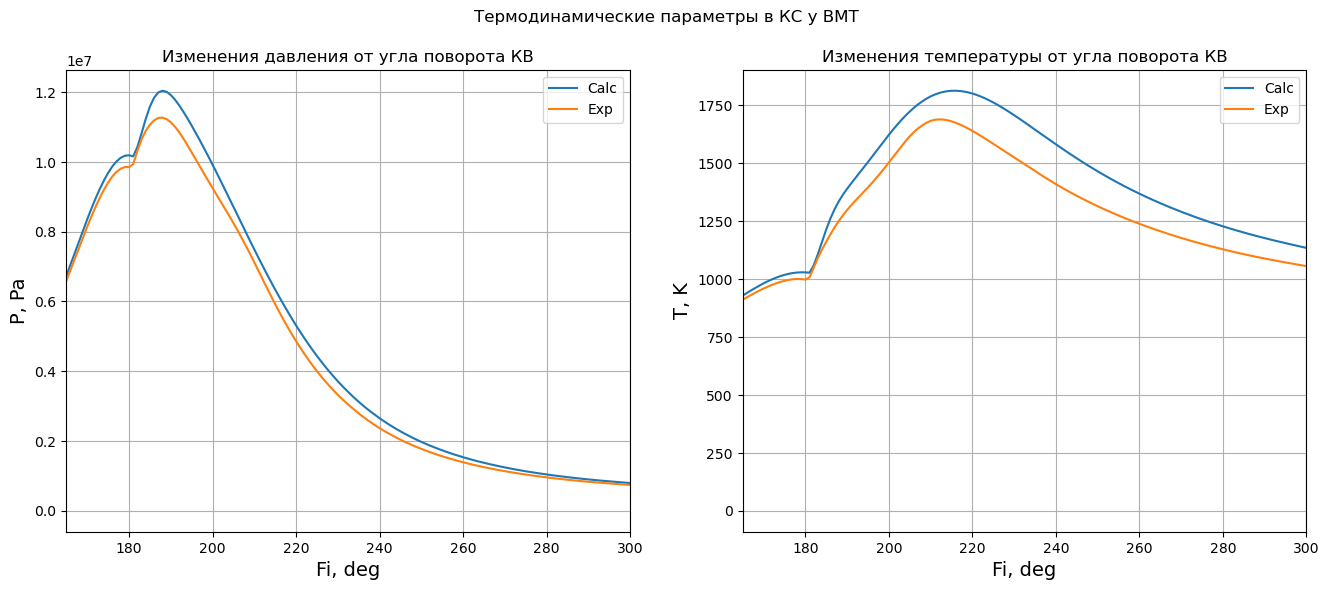

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Термодинамические параметры в КС у ВМТ')
# График давления
ax[0].set_title('Изменения давления от угла поворота КВ')
ax[0].set_ylabel('P, Pa', fontsize=14)
ax[0].set_xlabel('Fi, deg', fontsize=14)
ax[0].plot(P, label = 'Calc')
ax[0].plot(exp['Pc']*1e5, label = 'Exp')

# График температуры
ax[1].set_title('Изменения температуры от угла поворота КВ')
ax[1].set_ylabel('T, K', fontsize=14)
ax[1].set_xlabel('Fi, deg', fontsize=14)
ax[1].plot(T, label = 'Calc')
ax[1].plot(exp['Tc'], label = 'Exp')
[[ax.legend(), ax.grid(True), ax.set_xlim([165, 300])] for ax in ax]

plt.show()

Графики состава смеси в КС

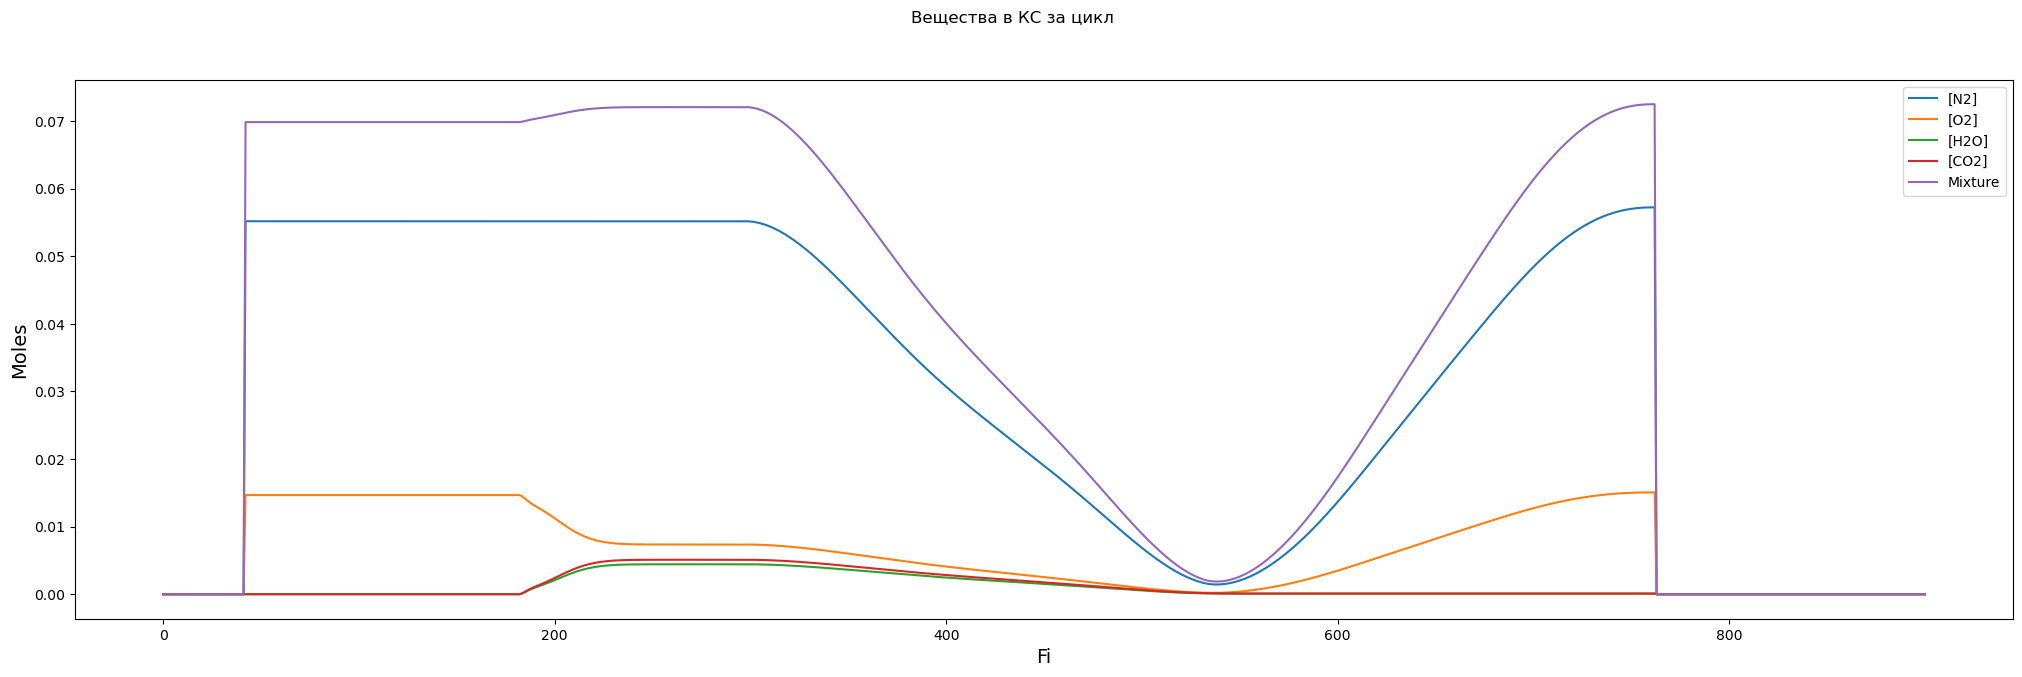

In [29]:
fig, ax = plt.subplots(figsize=(25,7))
plt.suptitle('Вещества в КС за цикл')
plt.plot(M['N2'], label = '[N2]')
plt.plot(M['O2'], label = '[O2]')
plt.plot(M['H2O'], label =  '[H2O]')
plt.plot(M['CO2'], label =  '[CO2]')
plt.plot(M['Mixture'], label =  'Mixture')
plt.ylabel('Moles', fontsize=14)
plt.xlabel('Fi', fontsize=14)
plt.legend()
plt.show()